In [41]:
# Import Libraries 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import ensemble
import seaborn as sns
from sklearn.learning_curve import learning_curve,validation_curve
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split,cross_val_score
from sklearn.svm import SVC
import re
import numpy as np
# Ensures graphs to be displayed in ipynb
%matplotlib inline   
sns.set()

In [42]:
# read both train and testdata into dataframe
titanic_df = pd.read_csv('train.csv',header=0)  # Always use header=0 to read header of csv files
titanic_test_df = pd.read_csv('test.csv',header=0)

# Merge Both files so that we get best average values
merged_df = pd.concat([titanic_df,titanic_test_df])

In [43]:
# we can see that the passenger details have been imported and we have all kind of dataformats available for each data field. 
# Next step is to munging the data 
# lets describe and get the info of the data to do so
titanic_df.info() 
print '*'* 40
titanic_test_df.info()
# we can observe that couple of information for age,embarked and cabin are missing. Out of which Embarked and Age seems relevent
print '*'*40
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [44]:
def clean_df(df):
    """ This Function processes Embarked Fill Missing values with 'S' 
                                Gender Convert to 0 or 1 for female and male
                                Family as ParentChild(Parch) + Sibling Spouse (SibSp)"""
    # we can see that we have maximum 'S' so let fill in with 'S' for those missing 2 values 
    df['Embarked'] = df['Embarked'].fillna('S')
    # as it is hard to work on string data in ML lets convert the 'sex' to 'gender' and have values 0,1 for m and f
    df['Gender'] = df['Sex'].map({'female':0, 'male':1}).astype(int)
    # now lets cleanup the parch (parent and children) and siblings 
    df['Family'] = df['Parch'] + df['SibSp']
    df = df.drop(['Parch','SibSp','Sex'],axis=1)
    
    # assign fare for missing values we are considering only the median fare of passenger class 3
    df['Fare'] = df['Fare'].fillna(cleaned_df[cleaned_df['Pclass']==3]['Fare'].median())
    return df

In [45]:
#  assign to a new varaible before that so the data is not lost
cleaned_df = titanic_df.copy()
# Lets display all datatypes that are not good for machine learning, like string/objects
cleaned_df = clean_df(cleaned_df)  # This Cleans Embarked,Gender and Family 
# cleaned_df.info()

# Clean test data too 
cleaned_test_df = titanic_test_df.copy()
cleaned_test_df = clean_df(cleaned_test_df) # This Cleans Embarked,Gender and Family 

# Clean Merged Data
cleaned_merged_df = merged_df.copy()
cleaned_merged_df = clean_df(cleaned_merged_df) 

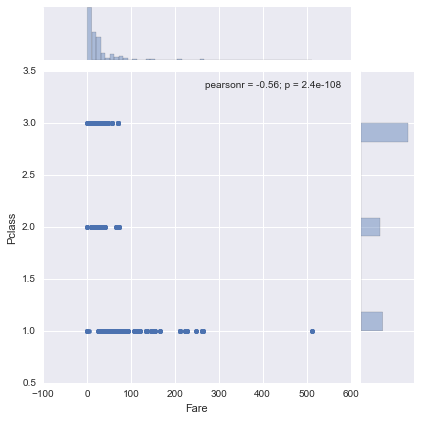

In [46]:
# Distribution of price over Passenger class
cleaned_merged_df[['Fare','Pclass']]
sns.jointplot('Fare','Pclass',cleaned_merged_df[['Fare','Pclass']])

In [47]:
# Now let us try to feature engineer the dataset 
# i.e create new features out of existing features , we also need to fix the age of the passengers which are still missing
#
# below is intermediate function to return only few titles apart from all , just to reduce simular features 
def compressTitle(title):
    if title in ['Mr','Don','Rev']:
        return 'Mr'
    elif title in ['Mrs','Lady','Mme']:
        return 'Mrs'
    elif title in ['Ms','Mlle','Miss']:
        return 'Miss'
    elif title in ['Master','Junior','Jonkheer']:
        return 'Master'
    else:
        return 'Sir'
def feature_engineer(df):
    """ This function will fix the missing values for age in DF,
        Fill Missing Values for Cabin and create binary features
        Fill Missing values for Embarked and create Binary features
        Try to Analyze the ticket number and get some information out of it"""
    # Work on age , But before that lets figure out the Passenger title from the name
    # Instead we can try to create a new model that predicts the age , using any linear regression model. 
    # But first lets try to split the name and try to find the title of the person. 
    df['Title'] = df['Name'].apply(lambda x: re.findall('\s+([a-zA-z]+)+\.',x)[0])
    # by Applying above regex we will get several titles like Capt,, Sir, etc.. which we may want to group similar ones
    # And lets have only 4 Titles , Master, Sir, Mr, Miss 
    
    df['Title'] = df['Title'].apply(compressTitle)
    # now that we got all the titles for all people we can take the age median for different groups seperately
    # we are doing in this way as it is not good to give the average age for infant and for the elder ones 
    all_titles = df['Title'].unique()   # get all titles that are compressed
    for title in all_titles:
        df.loc[df['Title']==title,'Age'] = df.loc[df['Title']==title,'Age'].fillna(df.loc[df['Title']==title]['Age'].median())
    # With this the age is also fixed now. 
    
    # Work on Cabin , We can observe that the cabin details are starting with charecters and followed by numerics
    # from the detail here http://www.titanicandco.com/inside.html we can find that the First charecter in each Cabin
    # is nothing but the DeckNumber We have A,B,C,D,E,F,G,L,O,T
    # in our data there are so many missing cabin numbers 
    # we can try to fill those missing cabin numbers if we try to extract the relations between people
    # i.e it is very likely if 2 persons are related will be in same cabin/deck 
    # May be we can get it from persons last name, However this model can some times cause problems 
    # as it is not mandate for people belonging to same last name also belong to same family 
    # Also there are atleast 102 last names in the dataset (train)
    # But just assign the last name or Family name for future purpose
    df['Lastname'] = df['Name'].apply(lambda x: re.findall('([A-Za-z]+)\,\s', x)[0])
    
    # Now lets work on deck values, first create new column deck and fill out all the missing values with U (Unknown)
    df['Cabin'] = df['Cabin'].fillna('U0')
    df['Deck'] = df['Cabin'].apply(lambda x:re.findall('([A-Za-z])+',x)[0])
    
    # As the charecter data wont be of much use, let us create binary features for Deck & Title
    df = pd.concat([df,pd.get_dummies(df['Deck']).rename(columns=lambda x: 'Deck_' + str(x))],axis=1)
    df = pd.concat([df,pd.get_dummies(df['Title']).rename(columns=lambda x: 'Title_' + str(x))],axis=1)
    # we also have G and O for decks which we dont have any record in train data but if we get test data then we get extra columns
    # Similary Deck T is available in Test but not in train
    if 'Deck_O' not in df.columns:
        df['Deck_O'] = 0
    if 'Deck_L' not in df.columns:
        df['Deck_L'] = 0
    if 'Deck_T' not in df.columns:
        df['Deck_T'] = 0
        
    # Create binary features for Embarked, we can see that most of Embarked as 'S'  so lets fill missing values with 'S'
    df['Embarked'] = df['Embarked'].fillna('S')
    df = pd.concat([df,pd.get_dummies(df['Embarked']).rename(columns=lambda x: 'Embarekd_' + str(x))],axis=1)
    return df

    


In [48]:
# Apply Above function 
final_merged_df = feature_engineer(cleaned_merged_df)

In [49]:
def normalize_data(df):
    """ This function will normalize the data so that the model value will not range to low to large extents"""
    for col in df.columns:
        if df[col].dtypes == object:
            pass
        else:
            if col == 'Survived' or col =='PassengerId':
                df = df
            else:
                df[col] = abs((df[col] - df[col].mean())/df[col].std())
            # this value is nothing but (original - mean)/Standard Deviation
    return df


In [50]:
final_merged_df = normalize_data(final_merged_df)
# Surely this feature normalization is not working 

In [51]:
# Assign values for which we have survied to train data and nan to test data for predections
final_df = final_merged_df[final_merged_df['Survived'].notnull()]
final_test_df = final_merged_df[final_merged_df['Survived'].isnull()]
# Drop all columns with Objects
train_df = final_df.drop(final_df.columns[final_df.dtypes == object], axis=1) 
test_df = final_test_df.drop(final_test_df.columns[final_test_df.dtypes == object], axis=1)
test_df = test_df.drop('Survived', axis=1)
trainCols = sorted(train_df.columns.tolist())
testCols = sorted(test_df.columns.tolist())
train_df = train_df[trainCols].fillna(0)
test_df = test_df[testCols].fillna(0)

In [52]:
# Random Forests Model
X = train_df.drop(['Survived','PassengerId'],axis=1)
y = train_df['Survived']
X_test = test_df.drop('PassengerId', axis=1)
rfModel = ensemble.RandomForestClassifier(n_estimators=900, random_state = 25, n_jobs=-1)
rfModel.fit(X,y)
y_pred = rfModel.predict(X_test).astype(int)
# print "AUC - ROC : ", roc_auc_score(y_pred,rfModel.oob_prediction)

In [53]:
rfModel.score(X_test,y_pred)

1.0

Before we submit the solution it is a good practice to see how the learning/validation curves looks like and also lets try to see how the confusion matrix will look like. 
Let us see on both Random Forest Regressor and also on the Logistic Regression classifier to see how it works on both of them
our Random Forest model is rfModel and Logistic Model is lrModel

In [54]:
parameter_grid = np.linspace(25, 100, 8).astype(int) # Varies the parameters from 25 to 200 8 times 
train_scores, validation_scores = validation_curve(rfModel, X, y, 
        "n_estimators", parameter_grid, cv=5)

depth_parameter_grid = np.linspace(2, 30, 5).astype(int) # Varies the parameters from 25 to 200 8 times 
depth_train_scores, depth_validation_scores = validation_curve(rfModel, X, y, 
        "max_depth", depth_parameter_grid, cv=5)

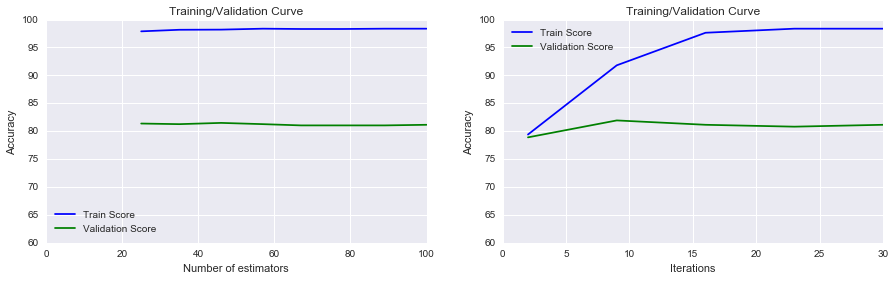

In [55]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(parameter_grid, 100  * np.average(train_scores, axis=1), color='blue',label='Train Score')
plt.plot(parameter_grid, 100  * np.average(validation_scores, axis=1), color='green', label='Validation Score')
plt.title('Training/Validation Curve')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.ylim(60,100)
plt.xlim(0,100)
plt.subplot(1,2,2)
plt.plot(depth_parameter_grid, 100  * np.average(depth_train_scores, axis=1), color='blue', label='Train Score')
plt.plot(depth_parameter_grid, 100  * np.average(depth_validation_scores, axis=1), color='green', label='Validation Score')
plt.title('Training/Validation Curve')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.ylim(60,100)
plt.xlim(0,30)
plt.legend(loc='best')

So the accuracy of the Training curve goes up for n_estimators greater than 55 or even better if n_estimators is more than 90 $ \text{n_estimators} = 90 $ And we can also see that the max_depth value of 25 or above will work good on our model. 
$ \text{max_depth} = 25 $

In [56]:
# Now lets train the model on learned parameters(modified)
rfModel = ensemble.RandomForestClassifier(n_estimators=90, random_state = 25, max_depth=25, n_jobs=-1)
rfModel.fit(X,y)
y_pred = rfModel.predict(X_test).astype(int)
rfModel.score(X,y)

0.98204264870931535

In [57]:
# This submission scored around 77.03 % accuracy, but not the best model yet. 

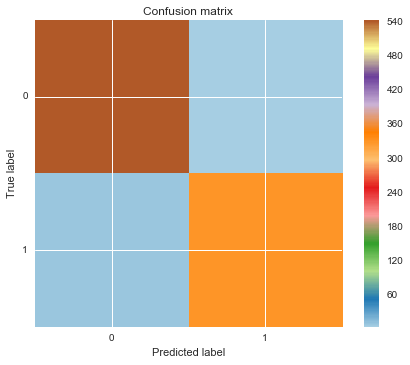

In [58]:
# let us also see how the confusion matrix for this data looks like
y_pred_train = rfModel.predict(X)
confusionMatrix = confusion_matrix(y, y_pred_train)
# plot confusion matrix
# Show confusion matrix
def plot_confusion_matrix(confusion_mat,n):
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Paired)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(n)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_confusion_matrix(confusionMatrix,2)

Confusion Matrix doesnt look great, but we can see that the diagnol which is predicting all true negatives accurately but only ~ 60% accurate about the true positives. 

Let us also now see the feature importance for this prediction

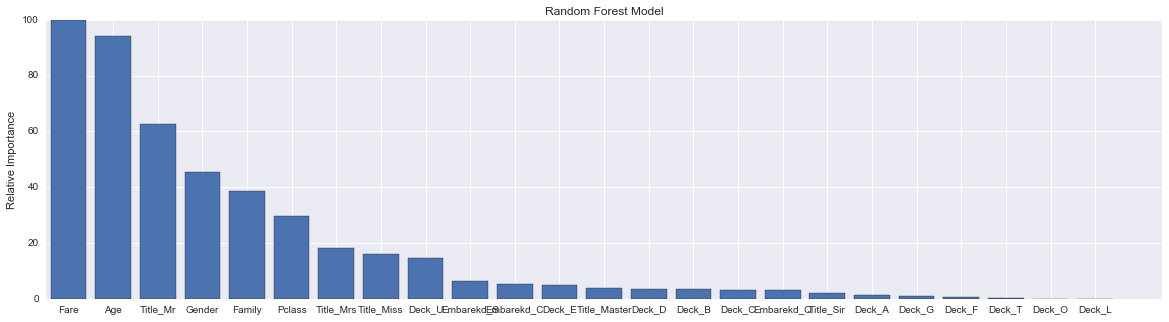

In [59]:
def plot_feature_importances(feature_importances, title, feature_names):
    # Normalize the importance values 
    feature_importances = 100.0 * (feature_importances / max(feature_importances))

    # Sort the values and flip them
    index_sorted = np.flipud(np.argsort(feature_importances))

    # Arrange the X ticks
    pos = np.arange(index_sorted.shape[0]) + 0.5

    # Plot the bar graph
    
    plt.figure(figsize=(20,5))
    plt.bar(pos, feature_importances[index_sorted], align='center')
    plt.xticks(pos, feature_names[index_sorted])
    plt.ylabel('Relative Importance')
    plt.title(title)
    plt.show()
    
plot_feature_importances(rfModel.feature_importances_, 'Random Forest Model', X.columns)

In [60]:
y_pred = rfModel.predict(X_test)
submission = pd.DataFrame({
        "PassengerId":test_df['PassengerId'],
        "Survived": y_pred.astype(int)
    })
submission.to_csv('titanic_rf.csv',index=False)

Trying to optimize using gridsearchcv
from sklearn.grid_search import GridSearchCV

In [61]:
from sklearn.grid_search import GridSearchCV

In [62]:
def train_test_model(model, hyperparameters, X_train, X_test, y_train, y_test,
                    folds = 5):
    """
    Given a [model] and a set of possible [hyperparameters], along with 
    matricies corresponding to hold-out cross-validation, returns a model w/ 
    optimized hyperparameters, and prints out model evaluation metrics.
    """
    optimized_model = GridSearchCV(model, hyperparameters, cv = folds, n_jobs = -1)
    optimized_model.fit(X_train, y_train)
    predicted = optimized_model.predict(X_test)
    print 'Optimized parameters:', optimized_model.best_params_
    print 'Model accuracy (hold-out):', optimized_model.score(X_test, y_test)
    kfold_score = np.mean(cross_val_score(
            optimized_model.best_estimator_, np.append(X_train, X_test, axis = 0), 
            np.append(y_train, y_test), cv = folds, n_jobs = -1))
    print 'Model accuracy ({0}-fold):'.format(str(folds)), kfold_score, '\n'
    return optimized_model

In [63]:
%%time
X_train, X_test_new, y_train, y_test_new = train_test_split(
    X,y,test_size = 0.2, random_state = 50)
rf_model = train_test_model(
    ensemble.RandomForestClassifier(n_estimators = 90, random_state = 25, n_jobs=-1), {
        'min_samples_split': [1, 3, 10],
        'min_samples_leaf': [1, 3, 10],
        'max_depth': [3, 25, None]}, 
    X_train, X_test_new, y_train, y_test_new)

Optimized parameters: {'min_samples_split': 10, 'max_depth': 25, 'min_samples_leaf': 3}
Model accuracy (hold-out): 0.832402234637
Model accuracy (5-fold): 0.832757970726 

Wall time: 31.9 s


In [64]:
rf_model_new = rf_model.best_estimator_
rf_model_new.fit(X,y)
y_pred = rf_model_new.predict(X_test)

#  Submission
submission = pd.DataFrame({
        "PassengerId":test_df['PassengerId'],
        "Survived": y_pred.astype(int)
    })
submission.to_csv('titanic_rf_new.csv',index=False)

Let us try all above for logistic regression also

In [65]:
# Logistic Regression
lrModel = linear_model.LogisticRegression(random_state = 25)
lrModel.fit(X,y)
y_pred = lrModel.predict(X_test).astype(int)
lrModel.score(X,y)

0.84175084175084181

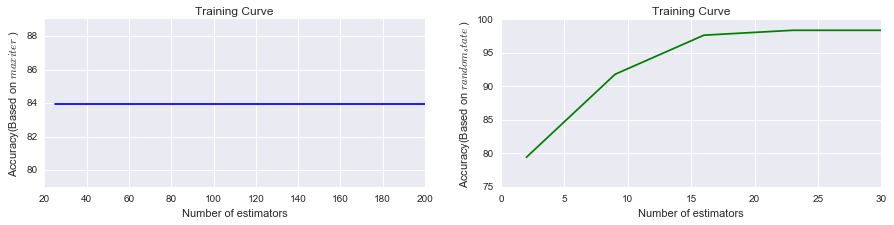

In [66]:
parameter_grid = np.linspace(25, 200, 8).astype(int) # Varies the parameters from 25 to 200 8 times 
train_scores, validation_scores = validation_curve(lrModel, X, y, 
        "max_iter", parameter_grid, cv=5)

rs_parameter_grid = np.linspace(2, 40, 5).astype(int) # Varies the parameters from 25 to 200 8 times 
rs_train_scores, depth_validation_scores = validation_curve(lrModel, X, y, 
        "random_state", rs_parameter_grid, cv=5)

plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(parameter_grid, 100  * np.average(train_scores, axis=1), color='blue')
plt.title('Training Curve')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy(Based on $ maxiter $ )')
plt.subplot(1,2,2)
plt.plot(depth_parameter_grid, 100  * np.average(depth_train_scores, axis=1), color='green')
plt.title('Training Curve')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy(Based on $ random_state $ )')

Lets see how the confusion matrix looks like

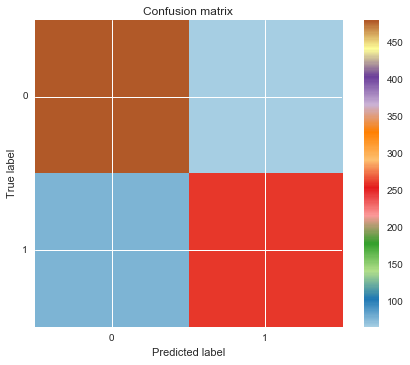

In [67]:
# let us also see how the confusion matrix for this data looks like
y_pred_train = lrModel.predict(X)
confusionMatrix = confusion_matrix(y, y_pred_train)
# plot confusion matrix
# Show confusion matrix
def plot_confusion_matrix(confusion_mat,n):
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Paired)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(n)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_confusion_matrix(confusionMatrix,2)

In [68]:
%%time
lr_model = train_test_model(
    linear_model.LogisticRegression(random_state = 25), {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'class_weight': [None, 'balanced'],
        'random_state': [1, 10, 25, 50]}, 
    X_train, X_test_new, y_train, y_test_new)

Optimized parameters: {'C': 100, 'random_state': 1, 'class_weight': None}
Model accuracy (hold-out): 0.815642458101
Model accuracy (5-fold): 0.830485458653 

Wall time: 10.7 s


In [69]:
lr_model_new = lr_model.best_estimator_
lr_model_new.fit(X,y)
y_pred = lr_model_new.predict(X_test)

#  Submission
submission = pd.DataFrame({
        "PassengerId":test_df['PassengerId'],
        "Survived": y_pred.astype(int)
    })
submission.to_csv('titanic_lr_new.csv',index=False)

In [70]:
%%time
svm_model = train_test_model(
    SVC(probability = True, random_state = 25), {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'gamma': np.logspace(-9, 3, 13)}, 
    X_train, X_test_new, y_train, y_test_new)

Optimized parameters: {'C': 100, 'gamma': 0.01}
Model accuracy (hold-out): 0.815642458101
Model accuracy (5-fold): 0.814798919209 

Wall time: 33.1 s


In [71]:
svm_model_new = svm_model.best_estimator_
svm_model_new.fit(X,y)
y_pred = svm_model_new.predict(X_test)

#  Submission
submission = pd.DataFrame({
        "PassengerId":test_df['PassengerId'],
        "Survived": y_pred.astype(int)
    })
submission.to_csv('titanic_svm_new.csv',index=False)

In [74]:
def majority_vote_ensemble(name, models_votes, train, outcomes, to_predict):
    """Creates a submission from a majority voting ensemble, given training/
    testing data and a list of models and votes.
    """
    model_results = []
    for model, votes in models_votes:
        model.fit(np.array(train), outcomes)
        probs = model.predict(np.array(to_predict))
        probs[probs == 0] = -1
        model_results.append((probs, votes))
    
    # Assemble the ensemble
    ensemble = pd.read_csv('test.csv')[['PassengerId']].assign(Survived = 0)
    for probs, votes in model_results:
        for i in range(0, votes):
            ensemble = ensemble.assign(Survived = lambda x: x.Survived + probs)
    (ensemble.assign(Survived = lambda x: np.where(x.Survived > 0, 1, 0))
     .to_csv(name, index = False))
    return None
    
    
models_votes = [
    (rf_model.best_estimator_, 2),
    (lr_model.best_estimator_, 2),
    (svm_model.best_estimator_,1)
]


majority_vote_ensemble('ensemble_majority_vote.csv', 
                       models_votes, X, y, X_test)